In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
import warnings

In [6]:
wandb.init(
    project="ResNet18",
    name="Run_1",
)
warnings.filterwarnings("ignore")

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)        
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)        
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
def ResNet18():
    return ResNet(ResidualBlock)

In [9]:
# Use the ResNet18 on Cifar-10
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os

# check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set hyperparameter
EPOCH = 5
pre_epoch = 0
BATCH_SIZE = 128
LR = 0.01

# prepare dataset and preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# labels in CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# define ResNet18
net = ResNet18().to(device)

# define loss funtion & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
#train
for epoch in range(pre_epoch, EPOCH):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        #prepare dataset
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        #forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print ac & loss in each batch
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        if (i + 1) % 100 == 0:
            print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% ' 
                % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))
        
    #get the ac with testdataset in each epoch
    print('Waiting Test...')
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('Test\'s ac is: %.3f%%' % (100 * correct / total))
        wandb.log({"Train Loss": sum_loss / (i + 1), 
                   "Test Accuracy": 100 * correct / total,
                   "Test img": [wandb.Image(images[0], caption=classes[labels[0]])]
                   })

print('Train has finished, total epoch is %d' % EPOCH)


Epoch: 1


[epoch:1, iter:100] Loss: 1.826 | Acc: 32.562% 
[epoch:1, iter:200] Loss: 1.654 | Acc: 39.012% 
[epoch:1, iter:300] Loss: 1.530 | Acc: 43.857% 
Waiting Test...
Test's ac is: 56.590%

Epoch: 2
[epoch:2, iter:491] Loss: 1.037 | Acc: 62.711% 
[epoch:2, iter:591] Loss: 1.006 | Acc: 63.938% 
[epoch:2, iter:691] Loss: 0.967 | Acc: 65.443% 
Waiting Test...
Test's ac is: 70.000%

Epoch: 3
[epoch:3, iter:882] Loss: 0.755 | Acc: 73.242% 
[epoch:3, iter:982] Loss: 0.733 | Acc: 74.117% 
[epoch:3, iter:1082] Loss: 0.724 | Acc: 74.560% 
Waiting Test...
Test's ac is: 75.100%

Epoch: 4
[epoch:4, iter:1273] Loss: 0.620 | Acc: 78.562% 
[epoch:4, iter:1373] Loss: 0.617 | Acc: 78.746% 
[epoch:4, iter:1473] Loss: 0.609 | Acc: 79.036% 
Waiting Test...
Test's ac is: 77.320%

Epoch: 5
[epoch:5, iter:1664] Loss: 0.528 | Acc: 81.422% 
[epoch:5, iter:1764] Loss: 0.531 | Acc: 81.410% 
[epoch:5, iter:1864] Loss: 0.522 | Acc: 81.648% 
Waiting Test...
Test's ac is: 81.180%
Train has finished, total epoch is 5


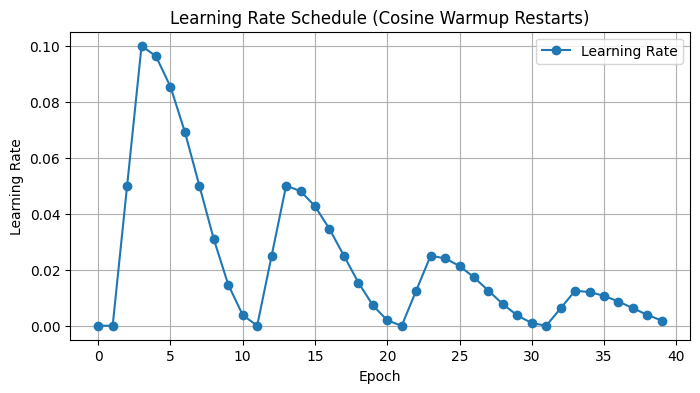

In [ ]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import _LRScheduler


# 커스텀 스케줄러(CosineAnnealingWarmUpRestarts) 정의

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))

        self.T_0 = T_0
        self.T_mult = T_mult
        self.T_up = T_up
        self.gamma = gamma

        self.T_i = T_0
        self.cycle = 0
        self.T_cur = last_epoch

        # Support multiple eta_max for multiple param groups
        if isinstance(eta_max, list) or isinstance(eta_max, tuple):
            if len(eta_max) != len(optimizer.param_groups):
                raise ValueError("Expected len(eta_max) == len(optimizer.param_groups), "
                                 "but got {} and {}".format(len(eta_max), len(optimizer.param_groups)))
            self.eta_max = list(eta_max)
        else:
            self.eta_max = [eta_max] * len(optimizer.param_groups)
        
        # Store base_eta_max for scaling
        self.base_eta_max = self.eta_max.copy()

        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [
                (eta_max - base_lr) * self.T_cur / self.T_up + base_lr 
                for base_lr, eta_max in zip(self.base_lrs, self.eta_max)
            ]
        else:
            return [
                base_lr + (eta_max - base_lr) * 
                (1 + math.cos(math.pi * (self.T_cur - self.T_up) / (self.T_i - self.T_up))) / 2
                for base_lr, eta_max in zip(self.base_lrs, self.eta_max)
            ]
    
    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** n
            else:
                self.T_i = self.T_0
                self.T_cur = epoch

        # Update eta_max for each param group
        self.eta_max = [base_eta_max * (self.gamma ** self.cycle) for base_eta_max in self.base_eta_max]
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr


# 예시용 간단한 모델
model = nn.Linear(10, 1)

# 옵티마이저 정의 (초기 lr 값은 스케줄러에서 점차 조정됨)
optimizer = optim.SGD(model.parameters(), lr=0.0)

# 스케줄러 생성
cycle_steps = 10       # 주기(period) 길이
warmup_steps = 2       # 워밍업 단계
eta_max = 0.1          # 최대 lr
scheduler = CosineAnnealingWarmUpRestarts(
    optimizer,
    T_0=cycle_steps,   
    T_mult=1,          
    eta_max=eta_max,   
    T_up=warmup_steps, 
    gamma=0.5          
)


epochs = 40  # 관찰할 에폭 수
lr_values = []

for epoch in range(epochs):

    lr_values.append(optimizer.param_groups[0]['lr'])
    

    scheduler.step(epoch)


plt.figure(figsize=(8, 4))
plt.plot(range(epochs), lr_values, marker='o', label='Learning Rate')
plt.title('Learning Rate Schedule (Cosine Warmup Restarts)')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)
plt.show()
